In [10]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../tools/mpl_finance_ext')))
import mpl_finance_ext as mfe

In [4]:


# The following indicator functions are copied (but modified) from
# the pandas-technical-indicators repository by Crypto-toolbox:
# https://github.com/Crypto-toolbox/pandas-technical-indicators

def relative_strength_index(df, n):
    """Calculate Relative Strength Index(RSI) for given data.
    :param df: pandas.DataFrame
    :param n:
    :return: pandas.DataFrame
    """
    i = df.index[0]
    UpI = [0]
    DoI = [0]
    while i + 1 <= df.index[-1]:
        UpMove = float(df.loc[i + 1, 'high']) - float(df.loc[i, 'high'])
        DoMove = float(df.loc[i, 'low']) - float(df.loc[i + 1, 'low'])
        if UpMove > DoMove and UpMove > 0:
            UpD = UpMove
        else:
            UpD = 0
        UpI.append(UpD)
        if DoMove > UpMove and DoMove > 0:
            DoD = DoMove
        else:
            DoD = 0
        DoI.append(DoD)
        i = i + 1
    UpI = pd.Series(UpI)

    DoI = pd.Series(DoI)
    PosDI = pd.Series(UpI.ewm(span=n, min_periods=n).mean())
    NegDI = pd.Series(DoI.ewm(span=n, min_periods=n).mean())

    # rsi = pd.Series(PosDI / (PosDI + NegDI), name='RSI_' + str(n))
    rsi = pd.DataFrame(PosDI / (PosDI + NegDI), columns=['RSI_' + str(n)])
    rsi = rsi.set_index(df.index)
    df = df.join(rsi)
    return df


def bollinger_bands(df, n, std):
    """
    :param df: pandas.DataFrame
    :param n:
    :return: pandas.DataFrame
    """

    ave = df['close'].rolling(window=n, center=False).mean()
    sd = df['close'].rolling(window=n, center=False).std()
    upband = pd.Series(ave + (sd * std), name='bband_upper_' + str(n))
    dnband = pd.Series(ave - (sd * std), name='bband_lower_' + str(n))
    ave = pd.Series(ave, name='bband_ave_' + str(n))

    df = df.join(pd.concat([upband, dnband, ave], axis=1))
    return df


def moving_average(df, n):
    """Calculate the moving average for the given data.
    :param df: pandas.DataFrame
    :param n:
    :return: pandas.DataFrame
    """
    MA = pd.Series(df['close'].rolling(n, min_periods=n).mean(), name='MA_' + str(n))
    df = df.join(MA)
    return df


def exponential_moving_average(df, n):
    """
    :param df: pandas.DataFrame
    :param n:
    :return: pandas.DataFrame
    """
    EMA = pd.Series(df['close'].ewm(span=n, min_periods=n).mean(), name='EMA_' + str(n))
    df = df.join(EMA)
    return df


In [34]:
def example_1(data, signals):
    # Example 1)
    # In this example we create a fig and an axis and
    # plot the candlestick chart plus some indicators
    # and the rsi on a seperate axis:

    # Create fig
    fig, _ = plt.subplots(facecolor=mfe.background_color)

    # Create first axis
    ax0 = plt.subplot2grid(
        (8, 4), (0, 0),
        rowspan=4, colspan=4,
        facecolor=mfe.background_color
    )

    # Add content to the first axis.
    # 1) Candlestick chart
    #    Alternative you can use plot_candlestick()
    #    instead of plot_filled_ohlc().
    #    The functionality is the same
    # 2) Bollinger Bands 20
    # 3) Moving Average 36
    # 4) Exponential Moving Average 8
    _, _ = mfe.plot_candlestick(
        fig=fig,
        axis=ax0,
        data=data,
        name='BTC_XRP_5min',
        signals=signals,
        plot_columns=[
            'bband_upper_20', 'bband_lower_20',
            'MA_36', 'EMA_8'
        ],
        draw_verticals=False,
        signal_evaluation=True,
        signal_evaluation_form='rectangle',  # 'arrow_1'
        disable_x_ticks=True,
    )

    # Create second axis
    ax1 = plt.subplot2grid(
        (8, 4), (4, 0),
        rowspan=4, colspan=4, sharex=ax0,
        facecolor=mfe.background_color
    )

    # Add content to the second axis.
    # 1) RSI 14
    mfe.plot(
        data=data,
        name='Chart 2',
        plot_columns=['RSI_14'],
        axis=ax1,
        fig=fig,
        xhline_red=0.8,
        xhline_green=0.2,
        gradient_fill=True
    )

    plt.show()
    
def example_2(data, signals):
    # Example 2)
    # Alternative to the first example we dont use
    # any given figure and axis.
    # If no axis is provided it will plt.show the
    # chart automatically. To disable this set show=False.
    # To save the chart set save='path_to_png.png'

    fig, ax = mfe.plot_filled_ohlc(
        data=data,
        name='BTC_XRP_5min',
        signals=signals,
        plot_columns=[
            'bband_upper_20', 'bband_lower_20',
            'MA_36', 'EMA_8'
        ],
        draw_verticals=False,
        signal_evaluation=True,
        signal_evaluation_form='rectangle',
        # save='BTC_XRP_5min_filled.png'
    )


def example_3(data, cs_patterns):
    # Example 2)
    # Alternative to the first example we dont use
    # any given figure and axis.
    # If no axis is provided it will plt.show the
    # chart automatically. To disable this set show=False.
    # To save the chart set save='path_to_png.png'

    fig, ax = mfe.plot_candlestick(
        data=data,
        name='BTC_XRP_5min',
        cs_patterns=cs_patterns,
        plot_columns=[
            'bband_upper_20', 'bband_lower_20',
            'MA_36', 'EMA_8'
        ],
        draw_verticals=False,
        # save='BTC_XRP_5min_candlestick.png'
    )


def example_4():
    fig, _ = plt.subplots(
        facecolor=mfe.background_color
    )

    # Plot returns in histogram
    ax2 = plt.subplot2grid(
        (8, 8), (0, 0),
        rowspan=4, colspan=8,
        facecolor=mfe.background_color
    )

    mu, sigma = 100, 15
    x = mu + sigma * np.random.randn(10000)

    mfe.hist(
        fig=fig,
        axis=ax2,
        data=x,
        bins=50,
        density=1,
        xlabel='Returns',
        ylabel='Probability density'
    )

    # Pattern histogram
    ax3 = plt.subplot2grid(
        (8, 4), (4, 1),
        rowspan=4, colspan=7,
        facecolor=mfe.background_color
    )

    pattern_history = [
        'berish_hanging_man',
        'bulish_hammer',
        'berish_dark_cloud_cover',
        'bulish_piercing_line',
        'berish_dark_cloud_cover',
        'berish_dark_cloud_cover',
        'bulish_hammer',
        'berish_hanging_man',
        'bulish_hammer',
        'bulish_morning_star',
    ]

    mfe.bar(
        fig=fig,
        axis=ax3,
        data=pattern_history,
        xlabel='Amount',
        ylabel='Patterns overall'
    )

    plt.subplots_adjust(
        left=.12, bottom=.13, right=.95,
        top=.97, hspace=1, wspace=1
    )
    plt.show()


def example_5():
    df = pd.read_csv('../data/input/stocks.csv', index_col=0).tail(1000)
    mfe.plot(df / df.iloc[0], gradient_fill=True)


def example_6():

    data = list()
    class_conditions = list()
    samples = 30

    # Create some data
    for i in range(samples):
        data.append((i, i, i))
        if i < samples / 2:
            class_conditions.append(1)
        else:
            class_conditions.append(2)

    # Graph everything
    mfe.scatter_3d(
        data=data,
        class_conditions=class_conditions,
        threshold=1,
        show=True,
        xlabel='X',
        ylabel='Y',
        zlabel='Z'
    )

In [26]:
# Load dataset -----------------------------------------------
data = pd.read_csv('../data/input/BTC_XRP_5min.csv', index_col=0)

# Calculate indicators ---------------------------------------
data = relative_strength_index(df=data, n=14)
data = bollinger_bands(df=data, n=20, std=4)
data = exponential_moving_average(df=data, n=8)
data = moving_average(df=data, n=36)

# Set signals ------------------------------------------------
# Structure: [(signal, index, price), ... ].
# Signal can be 'BUY' or 'SELL'

# Some manually picked examples
signals = [
    ('BUY', 12, 0.69), ('SELL', 27, 0.7028),
    ('BUY', 56, 0.6563), ('SELL', 81, 0.6854),
    ('BUY', 106, 0.665), ('SELL', 165, 0.640),
    ('BUY', 183, 0.66), ('SELL', 202, 0.7063),
]

# One manually picked candlestick pattern
patterns = [
    ['inverted_hammer', 12, 13]
]

In [ ]:
# Examples ---------------------------------------------------
example_1(data=data, signals=signals)

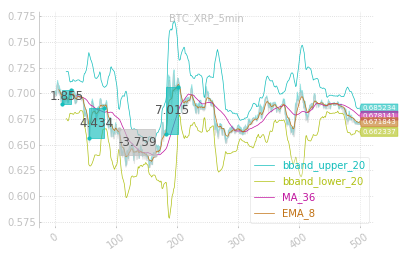

In [28]:
example_2(data=data, signals=signals)

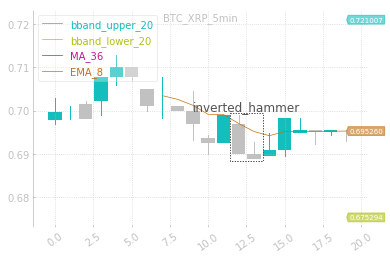

In [29]:
example_3(data=data.head(20), cs_patterns=patterns)

In [30]:
example_4()

AttributeError: Unknown property density

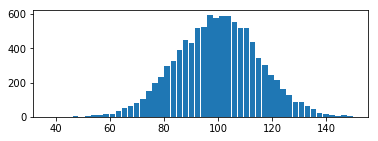

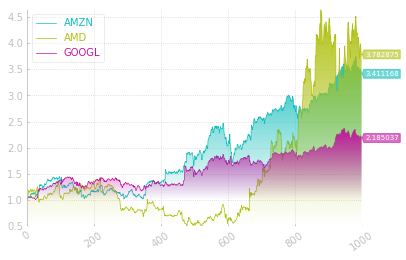

In [35]:
example_5()

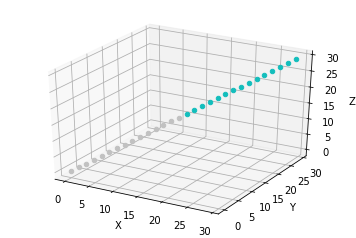

In [36]:
example_6()